In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import re
import nltk
import contractions
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/nasar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nasar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nasar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('processed_tweets.csv')

# Building inverted index 

In [3]:
def extract_tweet_vocabulary(tweet, docId):
    return {term: docId for term in tweet.split(' ')}

In [4]:
def merge_dicts(dicts):
    vocab = defaultdict(list)
    for dic in dicts:
        for term in dic:
            vocab[term].append(dic[term])
    return dict(vocab)

In [5]:
tweets_dicts = map(extract_tweet_vocabulary, df['Tweet'], df['DocID'])
vocabulary = merge_dicts(tweets_dicts)
print(f"Vocabulary has {len(vocabulary)} words")

Vocabulary has 10671 words


## Propose test queries

In [6]:
def build_TF_IDF(df, vocabulary):
    terms = vocabulary.keys()
    docs = df.DocID
    N = len(docs)
    tf_idf = dict()
    
    for doc in docs:
        tf_idf[doc] = {}
    
    for term in terms:
        for doc in vocabulary[term]:
            tf = df[df.DocID == doc].Tweet.iloc[0].split().count(term)
            if tf>0:
                df_i = len(vocabulary[term])
                tf_idf[doc][term] = (1+np.log(tf))*np.log(N/df_i)
            else:
                tf_idf[doc][term] = 0
    return tf_idf

In [7]:
def find_doc2norm(tf_idf):
    docs = tf_idf.keys()
    doc2norm = {}
    for doc in docs:
        doc2norm[doc] = np.linalg.norm(np.array(list(tf_idf[doc].values())))
    return doc2norm

In [8]:
def find_term2sum(tf_idf):
    terms = vocabulary.keys()
    docs = tf_idf.keys()
    term2sum = {term:0 for term in terms}
    for doc in docs:
        for term, value in tf_idf[doc].items():
            term2sum[term] += value
    term2sum = {t: v for t, v in sorted(term2sum.items(), key=lambda item: item[1], reverse=True)}
    return term2sum

In [ ]:
tf_idf = build_TF_IDF(df, vocabulary)
print(tf_idf)

In [10]:
doc2norm = find_doc2norm(tf_idf)
term2sum = find_term2sum(tf_idf)

In [11]:
top = 20
print(f"Top {top} terms:")
for i in range(top):
    term, value = list(term2sum.items())[i]
    print(f"\t{value} -> {term} ")

Top 20 terms:
	1431.550904893792 -> florida 
	1383.119940611485 -> hurrican 
	1353.611241498308 -> ian 
	981.8070760038978 -> amp 
	962.6318986223986 -> help 
	878.8508807261255 -> storm 
	794.7542557615245 -> flood 
	779.361058496029 -> power 
	763.8723112670441 -> carolina 
	721.5594989731698 -> go 
	719.9749917232326 -> south 
	717.5405051743975 -> peopl 
	703.8804288243131 -> make 
	697.07497650128 -> wind 
	692.1225245976001 -> landfal 
	673.1614057906999 -> damag 
	642.3890813702398 -> impact 
	641.8769650785212 -> safe 
	641.0670835188777 -> get 
	637.6271428214658 -> u 


From these results whe have concluded that some queries could be:

Q1="florida hurrican"

Q2="help people in florida"

Q3="hurrican ian major damages"

Q4="storm impact in Florida"

Q5="floodings in the south"

## Rank your results

In [12]:
def build_terms(line):
    """
    Preprocess the tweet content removing stop words, contractionas and urls
    lemmatizing and stemming words to keep a single word for each family of words
    transforming in lowercase, removing special characters [#, @, .] 
    (since it is included in another column on the dataframe)
    
    return tokenized tweet (list of words after applying the previous steps).
    
    Argument:
    line -- string (tweet) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
    ## START CODE
    line = line.lower() ##Transform in lowercase
    line = re.sub(r"[^A-Za-z 0-9 ']+", '', line) # remove emojis and any other special character
    stop_words = set(stopwords.words("english")) # removing stopwords
    line = ' '.join([contractions.fix(x) for x in line.split(' ')]) # expaning verb abreviations: i'll -> i will 
    line = re.sub("'", '', line) 
    line = line.split(' ')
    line = [x for x in line if x and x not in stop_words]
    line = filter(lambda x:x[0:5]!='https', line) # removing links
    line = [x for x in line]
    ps = PorterStemmer() 
    lemmatizer = WordNetLemmatizer() 
    line = [lemmatizer.lemmatize(x) for x in line] # keeping the singular form of each noun: feet --> foot
    line = [ps.stem(x) for x in line] # keeping the root of each family of words: dancer --> danc
    
    ## END CODE
    return ' '.join(line)

In [13]:
def rank(query, tf_idf, vocabulary):
    N = len(tf_idf.keys())
    terms_query = build_terms(query).split()
    terms_q = list(set(terms_query))
    tf_idf_q = dict()
    
    for term_q in terms_q:
        f_iq = terms_query.count(term_q)
        if term_q not in vocabulary:
            continue
        df_i = len([doc for doc in vocabulary[term_q] if doc in tf_idf.keys()])
        if df_i>0:
            tf_idf_q[term_q] = (1+np.log(f_iq))*np.log(N/df_i)
        else:
            tf_idf_q[term_q]=0
    q_norm = np.linalg.norm(np.array(list(tf_idf_q.values())))
    doc2score = dict()
    
    doc2norm = find_doc2norm(tf_idf)
    
    for doc, dix in tf_idf.items():
        dot_product = 0
        for term, value in dix.items():
            if term in tf_idf_q.keys():
                dot_product += value * tf_idf_q[term]
        doc2score[doc] = dot_product / (doc2norm[doc] * q_norm)
    doc2score = {t: v for t, v in sorted(doc2score.items(), key=lambda item: item[1], reverse=True)}
    return doc2score

In [14]:
Q1="florida hurrican"
Q2="help people in florida"
Q3="hurrican ian major damages"
Q4="storm impact in Florida"
Q5="floodings in the south"

In [15]:
doc2score_Q1 = rank(Q1, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 1:")
for i in range(top):
    doc, score = list(doc2score_Q1.items())[i]
    print(f"\t{doc} -> {score} -> {df[df.DocID == doc].Tweet.iloc[0]}")

Top 10 docs for query 1:
	doc_640 -> 0.5015566349200697 -> hurrican ian hurricaneian
	doc_733 -> 0.32852179583698915 -> experi hurrican check hurricaneian bless hurrican florida
	doc_1071 -> 0.29589174718605576 -> hope peopl florida safe n sound hurrican ian hurricaneian florida
	doc_2877 -> 0.2574191208525311 -> hurrican ian cuba florida south carolinahurricaneian
	doc_1993 -> 0.25623464377621896 -> help affect hurrican ian florida via usatoday hurricaneian
	doc_2051 -> 0.25623464377621896 -> help affect hurrican ian florida via usatoday hurricaneian
	doc_2108 -> 0.25623464377621896 -> help affect hurrican ian florida via usatoday hurricaneian
	doc_2183 -> 0.25623464377621896 -> help affect hurrican ian florida via usatoday hurricaneian
	doc_2637 -> 0.2424094796463337 -> repost gma imag show hurrican ian destruct make landfal florida west coast categori 4 hurrican hurricaneian hurrican weather florida news
	doc_3848 -> 0.23601494687859806 -> care florida hurricaneian


In [16]:
doc2score_Q2 = rank(Q2, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 2:")
for i in range(top):
    doc, score = list(doc2score_Q2.items())[i]
    print(f"\t{doc} -> {score} -> {df[df.DocID == doc].Tweet.iloc[0]}")

Top 10 docs for query 2:
	doc_3682 -> 0.37023387134694796 -> good morn love yesterday employ sent email donat help florida hurricaneian victim want hear peopl help theme park ok concern peopl peopl help
	doc_812 -> 0.34574116813941735 -> look organ provid help hurricaneian victim central florida tri connect group peopl need help know group peopl contact
	doc_2817 -> 0.3252392212025381 -> hurricaneian impact million peopl name florida cuba organ donat support help need
	doc_477 -> 0.32331316732387927 -> help way hurricaneian
	doc_898 -> 0.30369425198511185 -> donaldjtrumpjr even tri open chariti help peopl florida recov hurricaneian
	doc_1071 -> 0.2999415370477475 -> hope peopl florida safe n sound hurrican ian hurricaneian florida
	doc_584 -> 0.2983730578974018 -> join fox support redcross relief effort help peopl affect hurricaneian
	doc_2726 -> 0.2983730578974018 -> join fox support redcross relief effort help peopl affect hurricaneian
	doc_2027 -> 0.2810946956282909 -> keycnewsnow t

In [17]:
doc2score_Q3 = rank(Q3, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 3:")
for i in range(top):
    doc, score = list(doc2score_Q3.items())[i]
    print(f"\t{doc} -> {score} -> {df[df.DocID == doc].Tweet.iloc[0]}")

Top 10 docs for query 3:
	doc_1083 -> 0.38804626917413254 -> flood major concern gardenc hurricaneian
	doc_640 -> 0.38434177295848754 -> hurrican ian hurricaneian
	doc_3288 -> 0.2689334506116603 -> still without power amp estim restor went hotel minor damag roof amp flood damag noth major everyth fridg amp freezer gone could much wors hurricaneian
	doc_2660 -> 0.2530435347684877 -> aftermath major storm awar potenti down power line hazard hurricaneian staysaf
	doc_1494 -> 0.2353773197996116 -> holi cow major flood kissimme via wftv hurricaneian 03
	doc_647 -> 0.22401974912104267 -> interest point discuss go forward build code state law chang tri mitig damag loss life result increas frequenc major hurrican landfal along conu hurricaneian
	doc_3752 -> 0.2091246087158529 -> iron hurricaneian hit democrat major miamidad broward counti govrondesanti would ask relief fund
	doc_1561 -> 0.20768761765003596 -> januari year ef2 tornado caus major damag iona southern fort myer flood like total ev

In [18]:
doc2score_Q4 = rank(Q4, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 4:")
for i in range(top):
    doc, score = list(doc2score_Q4.items())[i]
    print(f"\t{doc} -> {score} -> {df[df.DocID == doc].Tweet.iloc[0]}")

Top 10 docs for query 4:
	doc_2045 -> 0.4365974215379949 -> hurrican ian left devast impact mani part florida join u keep impact storm thought
	doc_1065 -> 0.353869704308813 -> thought neighbor florida impact devast hurricaneian
	doc_3406 -> 0.3418966093792788 -> thought prayer impact hurricaneian
	doc_611 -> 0.31966865497209546 -> thought resid florida impact hurricaneian learn storm respons along tip affect sever weather
	doc_1519 -> 0.3188829853498068 -> impact hurrican ian thought prayer hurricaneian
	doc_1029 -> 0.30023694973777965 -> thought prayer everyon impact hurricaneian
	doc_3956 -> 0.29640674751967616 -> great way help impact hurricaneian
	doc_965 -> 0.27310342211111505 -> donat fund fellow american florida impact hurricaneian go
	doc_446 -> 0.26903046992799906 -> pawley island polic keep tab hurricaneian storm impact area
	doc_3475 -> 0.26667223300762155 -> yesterday storm hurricaneian


In [19]:
doc2score_Q5 = rank(Q5, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 5:")
for i in range(top):
    doc, score = list(doc2score_Q5.items())[i]
    print(f"\t{doc} -> {score} -> {df[df.DocID == doc].Tweet.iloc[0]}")

Top 10 docs for query 5:
	doc_254 -> 0.5127787107942561 -> south carolina hurricaneian
	doc_174 -> 0.4146748622439571 -> south carolina hurricaneian go
	doc_493 -> 0.40233752258738564 -> south myrtl beach south carolina hurricaneian ian scwx
	doc_249 -> 0.35646005431101074 -> hurricaneian make landfal south carolina
	doc_2505 -> 0.35646005431101074 -> hurricaneian make landfal south carolina
	doc_1289 -> 0.3368443875337799 -> flood garden citi south carolina gardenc southcarolina hurricaneian
	doc_2484 -> 0.30659109543927177 -> flood trap mani florida ian head south carolinahttpstcozmufhc9egm hurricaneian
	doc_2545 -> 0.2904761640226492 -> busi open south florida hurricaneian
	doc_1435 -> 0.26770369849230224 -> charleston south carolina flood mani road around citi impass rain expect hurricaneian charleston southcarolina scwx
	doc_2204 -> 0.26573923268110056 -> get latest hurricaneian near south carolina


# Evaluation

In [20]:
df_evaluation = pd.read_csv('data/evaluation_gt.csv')

In [21]:
len(df_evaluation)

60

In [22]:
df_evaluation.head()

,doc,query_id,label
0,doc_12,1,1
1,doc_9,1,1
2,doc_18,1,1
3,doc_45,1,1
4,doc_501,1,1


In [23]:
E_Q1 = "Landfall in South Carolina"
E_Q2 = "Help and recovery during the hurricane disaster"
E_Q3 = "Floodings in South Carolina"

In [24]:
evaluation_q1 = df_evaluation[df_evaluation.query_id == 1]
evaluation_q2 = df_evaluation[df_evaluation.query_id == 2]
evaluation_q3 = df_evaluation[df_evaluation.query_id == 3]

In [25]:
def prior_evaluation(query, evaluation, K, ranking):
    print("Prior Evaluation for query:", query)
    docID_retrieved = [x[0] for x in ranking[0:K]]
    scores = [x[1] for x in ranking[0:K]]
    
    docs_retieved = evaluation[evaluation.doc.isin(docID_retrieved)]
    num_rel_docs_retrieved = docs_retieved.label.sum()
    precision = num_rel_docs_retrieved/K
    print("Precision@"+str(K)+":", precision)
    
    num_relevant_docs = len(evaluation[evaluation.label==1])
    recall = num_rel_docs_retrieved/num_relevant_docs
    print("Recall@"+str(K)+":", recall)
    
    avg_precision = 0
    docs_relevant = 0
    rr = 0
    for i in range(K):
        if docs_retieved[docs_retieved.doc == docID_retrieved[i]].label.iloc[0]==1:
            if docs_relevant == 0:
                rr = 1/(i+1)
            docs_relevant+=1
            avg_precision+=docs_relevant/(i+1)
    avg_precision = avg_precision/num_rel_docs_retrieved
    print("Average Precision@"+str(K)+":", avg_precision)
    
    F_1 = 2*(1/(1/precision+1/recall))
    print("F1-Score:", F_1)
    
    actual = 0
    ideal = 0
    for i in range(K):
        rel = docs_retieved[docs_retieved.doc == docID_retrieved[i]].label.iloc[0]
        actual += (2**rel-1)/np.log(2+i)
        ideal += 1/np.log(2+1)
    ndcg = actual/ideal
    print("Normalized Discounted Cumulative Gain (NDCG):", ndcg)
    
    return precision, recall, avg_precision, rr, F_1, ndcg

In [26]:
def evaluate_system(avg_p,rr):
    m_a_p = sum(avg_p)/len(avg_p)
    print("Mean Average Precision (MAP):", m_a_p)
    
    mrr= sum(rr)/len(rr)
    print("Mean Reciprocal Rank (MRR):", mrr)

In [27]:
tf_idf_Q1 = {k: tf_idf[k] for k in set(evaluation_q1.doc)}
tf_idf_Q2 = {k: tf_idf[k] for k in set(evaluation_q2.doc)}
tf_idf_Q3 = {k: tf_idf[k] for k in set(evaluation_q3.doc)}

In [28]:
ranking_E_Q1 = list(rank(E_Q1, tf_idf_Q1, vocabulary).items())
ranking_E_Q2 = list(rank(E_Q2, tf_idf_Q2, vocabulary).items())
ranking_E_Q3 = list(rank(E_Q3, tf_idf_Q3, vocabulary).items())

In [29]:
p1, r1, avg_p_1, rr_1, F1_1, ndcg_1 = prior_evaluation(E_Q1, evaluation_q1, top, ranking_E_Q1)

Prior Evaluation for query: Landfall in South Carolina
Precision@10: 1.0
Recall@10: 1.0
Average Precision@10: 1.0
F1-Score: 1.0
Normalized Discounted Cumulative Gain (NDCG): 0.7201371170671467


In [30]:
p2, r2, avg_p_2, rr_2, F1_2, ndcg_2 = prior_evaluation(E_Q2, evaluation_q2, top, ranking_E_Q2)

Prior Evaluation for query: Help and recovery during the hurricane disaster
Precision@10: 0.8
Recall@10: 0.8
Average Precision@10: 0.9085317460317459
F1-Score: 0.8
Normalized Discounted Cumulative Gain (NDCG): 0.6088223977906009


In [31]:
p3, r3, avg_p_3, rr_3, F1_3, ndcg_3 = prior_evaluation(E_Q3, evaluation_q3, top, ranking_E_Q3)

Prior Evaluation for query: Floodings in South Carolina
Precision@10: 0.9
Recall@10: 0.9
Average Precision@10: 0.7777777777777778
F1-Score: 0.8999999999999999
Normalized Discounted Cumulative Gain (NDCG): 0.5766093005960478


In [32]:
avg_p_E = [avg_p_1, avg_p_2, avg_p_3]
rr_E = [rr_1, rr_2, rr_3]
evaluate_system(avg_p_E, rr_E)

Mean Average Precision (MAP): 0.895436507936508
Mean Reciprocal Rank (MRR): 1.0


## Evaluation of our 5 queries

In [33]:
my_evaluation = pd.read_csv('data/my_evaluation - my_evaluation.csv')

In [34]:
my_evaluation.head()

,doc,Label Q1,Label Q2,Label Q3,Label Q4,Label Q5
0,doc_1036,0,0,0,0,0
1,doc_1060,0,0,0,0,0
2,doc_1068,1,1,0,1,0
3,doc_1108,0,0,0,0,0
4,doc_1202,1,1,0,1,0


In [35]:
my_evaluation_Q1 = my_evaluation.copy().drop(columns=['Label Q2','Label Q3','Label Q4','Label Q5']).rename(columns={'Label Q1': 'label'})
my_evaluation_Q2 = my_evaluation.copy().drop(columns=['Label Q1','Label Q3','Label Q4','Label Q5']).rename(columns={'Label Q2': 'label'})
my_evaluation_Q3 = my_evaluation.copy().drop(columns=['Label Q2','Label Q1','Label Q4','Label Q5']).rename(columns={'Label Q3': 'label'})
my_evaluation_Q4 = my_evaluation.copy().drop(columns=['Label Q2','Label Q3','Label Q1','Label Q5']).rename(columns={'Label Q4': 'label'})
my_evaluation_Q5 = my_evaluation.copy().drop(columns=['Label Q2','Label Q3','Label Q4','Label Q1']).rename(columns={'Label Q5': 'label'})

In [36]:
tf_idfQ1 = {k: tf_idf[k] for k in set(my_evaluation_Q1.doc)}
tf_idfQ2 = {k: tf_idf[k] for k in set(my_evaluation_Q2.doc)}
tf_idfQ3 = {k: tf_idf[k] for k in set(my_evaluation_Q3.doc)}
tf_idfQ4 = {k: tf_idf[k] for k in set(my_evaluation_Q4.doc)}
tf_idfQ5 = {k: tf_idf[k] for k in set(my_evaluation_Q5.doc)}

In [37]:
ranking_Q1 = list(rank(Q1, tf_idfQ1, vocabulary).items())
ranking_Q2 = list(rank(Q2, tf_idfQ2, vocabulary).items())
ranking_Q3 = list(rank(Q3, tf_idfQ3, vocabulary).items())
ranking_Q4 = list(rank(Q4, tf_idfQ4, vocabulary).items())
ranking_Q5 = list(rank(Q5, tf_idfQ5, vocabulary).items())

In [38]:
p1_, r1_, avg_p_1_, rr_1_, F1_1_, ndcg_1_ = prior_evaluation(Q1, my_evaluation_Q1, top, ranking_Q1)

Prior Evaluation for query: florida hurrican
Precision@10: 0.6
Recall@10: 0.5454545454545454
Average Precision@10: 0.8374999999999999
F1-Score: 0.5714285714285714
Normalized Discounted Cumulative Gain (NDCG): 0.49487478538385204


In [39]:
p2_, r2_, avg_p_2_, rr_2_, F1_2_, ndcg_2_ = prior_evaluation(Q2, my_evaluation_Q2, top, ranking_Q2)

Prior Evaluation for query: help people in florida
Precision@10: 0.4
Recall@10: 0.6666666666666666
Average Precision@10: 0.85
F1-Score: 0.5
Normalized Discounted Cumulative Gain (NDCG): 0.38356006610730614


In [40]:
p3_, r3_, avg_p_3_, rr_3_, F1_3_, ndcg_3_ = prior_evaluation(Q3, my_evaluation_Q3, top, ranking_Q3)

Prior Evaluation for query: hurrican ian major damages
Precision@10: 0.3
Recall@10: 0.5
Average Precision@10: 0.5535714285714285
F1-Score: 0.37499999999999994
Normalized Discounted Cumulative Gain (NDCG): 0.2613283334294875


In [41]:
p4_, r4_, avg_p_4_, rr_4_, F1_4_, ndcg_4_ = prior_evaluation(Q4, my_evaluation_Q4, top, ranking_Q4)

Prior Evaluation for query: storm impact in Florida
Precision@10: 0.6
Recall@10: 0.6666666666666666
Average Precision@10: 0.4675925925925926
F1-Score: 0.631578947368421
Normalized Discounted Cumulative Gain (NDCG): 0.3295606586016012


In [42]:
p5_, r5_, avg_p_5_, rr_5_, F1_5_, ndcg_5_ = prior_evaluation(Q5, my_evaluation_Q5, top, ranking_Q5)

Prior Evaluation for query: floodings in the south
Precision@10: 0.4
Recall@10: 0.8
Average Precision@10: 0.85
F1-Score: 0.5333333333333333
Normalized Discounted Cumulative Gain (NDCG): 0.38356006610730614


In [43]:
avg_p = [avg_p_1_, avg_p_2_, avg_p_3_, avg_p_4_, avg_p_5_]
rr = [rr_1_, rr_2_, rr_3_, rr_4_, rr_5_]
evaluate_system(avg_p, rr)

Mean Average Precision (MAP): 0.7117328042328042
Mean Reciprocal Rank (MRR): 0.85


# 2-dimensional representation

Choose one vector representation, TF-IDF or word2vec, and represent the tweets in a
two-dimensional scatter plot through the T-SNE (T-distributed Stochastic Neighbor
Embedding) algorithm. To do so, you may need first to represent the word as a
vector, and then the tweet, i.e., resulted as the average value over the words
involved. Any other option rather than T-SNE may be used, but needs to be justified.
HINT: You don’t have to know all the theoretical details used in T-SNE, just use the
proper library and generate the output and play with it.
Also, you can choose to perform an alternative method to generate a 2-dimensional
representation for the word embeddings (like PCA).

In [44]:
vectors = pd.DataFrame.from_dict(tf_idf)

In [45]:
vectors.fillna(0, inplace=True)

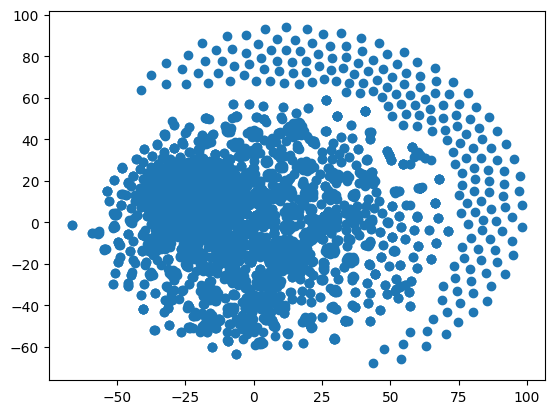

In [46]:
X = np.array([list(vectors[t]) for t in tf_idf.keys()], dtype=object)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
x_ = [p[0] for p in X_embedded]
y_ = [p[1] for p in X_embedded]
matplotlib.pyplot.scatter(x_, y_)